# NLTK

In [1]:
import numpy as np
import pandas as pd
import config
import jupyter_service
import sys
import matplotlib.pyplot as plt
from dbcontext import Context
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.display.float_format = '{:.2f}'.format
print(sys.version, np.__version__, pd.__version__, config.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)] 2.0.2 2.2.3 0.1.0.Alpha


In [2]:
context = Context()
context.create(echo=False)
service = jupyter_service.JupyterService(context)
print(config.connection_string)

postgresql://postgres:sa@localhost:5432/yt1


Most used topics

In [3]:
sql = """SELECT avg(count) as average, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY count) as median_, PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY count) as quartile, PERCENTILE_CONT(0.1) WITHIN GROUP(ORDER BY count) as decile, PERCENTILE_CONT(0.01) WITHIN GROUP(ORDER BY count) as percentile FROM topic where source='nltk' and count > 1"""
df = service.get_by_sql(sql)
avg=57
median=6
percentile=2
nb_topic=588
nb_form=15854
df

,average,median_,quartile,decile,percentile
0,144.63,10.00,3.00,2.00,2.00


In [4]:
sql = """select label, count from topic where source='nltk' and count > 1 order by count desc"""
df = service.get_by_sql(sql)
df

,label,count
0,happy,5754
1,respect,3747
2,peace,3515
3,health,3509
4,could,3434
...,...,...
691,bounds,2
692,blog,2
693,awaken,2
694,lawful,2


Most used topics by forms

In [5]:
sql = """select topic.label, count(form_topic.id) as nb_form from topic
join form_topic on form_topic.topic_id=topic.id
where source='nltk'
group by topic.id
order by nb_form desc"""
df = service.get_by_sql(sql)
df.head(10)

,label,nb_form
0,happy,5118
1,peace,3485
2,world,3219
3,health,3117
4,respect,3053
5,good,2838
6,could,2834
7,life,2320
8,better,2295
9,success,1997


Lemas

In [7]:
topic = "happy"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='nltk'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)


,topic_label,lema_label,count
0,happy,happy,2441
1,happy,happiness,1796
2,happy,harmony,208
3,happy,happily,70
4,happy,bring,62
5,happy,being_happy,61
6,happy,married,57
7,happy,makes,57
8,happy,hate,54
9,happy,hard,50


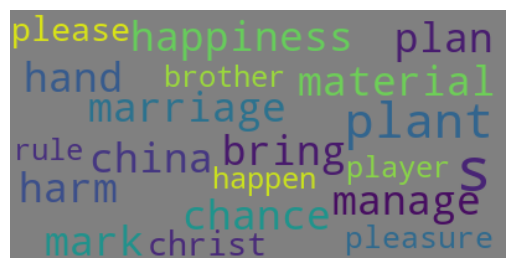

In [8]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
empathy_category="f"

Empty Negative Score

In [31]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='nltk'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='nltk'
and stat.{empathy_category}_category=0
and stat.q1_2_sentiment < -0.33
and form_topic.question_nb=12
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)


,id,label,nb_neg_form,nb_form,ratio
0,7701,want,14,1661,0.12
1,7663,poverty,8,708,0.09
2,7657,happy,19,5118,0.07
3,7664,respect,14,3053,0.06
4,7673,development,10,1566,0.06
5,7700,health,13,3117,0.05
6,7652,stable,8,1628,0.04
7,7786,family,7,1373,0.04
8,7667,better,9,2295,0.04
9,7731,good,9,2838,0.03


In [10]:
topic = "respect"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='nltk'
order by lema.count desc"""
df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,respect,respect,232
1,respect,parents,130
2,respect,reduce,125
3,respect,understanding,102
4,respect,unity,94
5,respect,understand,88
6,respect,realize,83
7,respect,resources,83
8,respect,united,71
9,respect,relationships,69


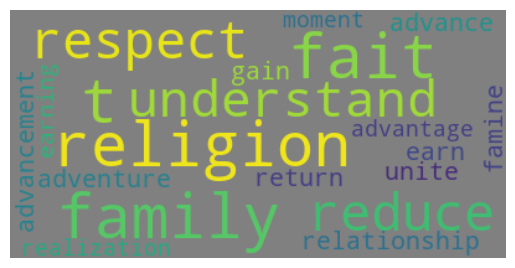

In [11]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

PD Positive Score

In [32]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='nltk'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='nltk'
and stat.{empathy_category}_category=2
and form_topic.question_nb=12
and stat.q1_2_sentiment > 0.33
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,7657,happy,1719,5118,577.37
1,7694,world,1363,3219,577.13
2,7681,wish,946,1765,507.03
3,7667,better,1010,2295,444.49
4,7731,good,1112,2838,435.71
5,7664,respect,1130,3053,418.24
6,7700,health,1123,3117,404.60
7,7654,could,1058,2834,394.98
8,7656,life,924,2320,368.01
9,7689,peace,1131,3485,367.05


In [13]:
topic = "happy"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='nltk'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count
0,happy,happy,2441
1,happy,happiness,1796
2,happy,harmony,208
3,happy,happily,70
4,happy,bring,62
5,happy,being_happy,61
6,happy,married,57
7,happy,makes,57
8,happy,hate,54
9,happy,hard,50


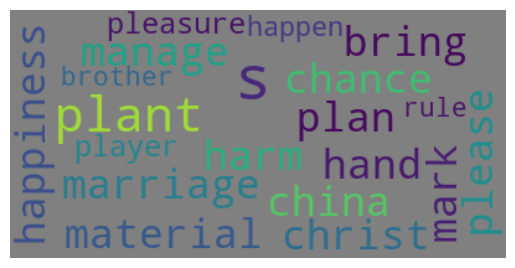

In [14]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Low Noise
857 topics
Low noise = 8
Very low = 1


In [15]:
low_noise = median
very_low_noise = percentile
thresold = nb_form / 1000
thresold, low_noise, very_low_noise

(15.854, 6, 2)

In [33]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='nltk'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='nltk'
and form_topic.question_nb=12
and stat.{empathy_category}_category=0
group by topic.id, sub_topic.nb_form
having count(form_topic.id) >= {very_low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df = df[df.label != "etre"]
df.head(10)

,id,label,nb_neg_form,nb_form,ratio
0,7727,recent,2,2,-0.26
1,7716,south,3,3,-0.34
2,8060,germany,2,3,-0.69
3,8142,exams,2,4,-1.12
4,8679,whenever,2,4,-1.12
5,8494,gestures,2,4,-1.12
6,8162,soldier,3,6,-1.63
7,8365,arts,2,6,-1.99
8,8244,eating,2,6,-1.99
9,8468,wrong,3,7,-2.07


In [17]:
topic = "millionaire"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='nltk'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count


In [34]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='nltk'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='nltk'
and form_topic.question_nb=12
and stat.{empathy_category}_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,7884,steps,7,8,-1.76
1,8227,labor,7,8,-1.76
2,8027,tour,8,9,-2.08
3,8550,webm,7,9,-2.19
4,8275,garden,7,9,-2.19
5,8446,authentic,8,10,-2.51
6,7954,wherever,8,10,-2.51
7,8191,judging,7,10,-2.62
8,8153,welcome,7,10,-2.62
9,8125,eternal,7,10,-2.62
